# Tiling and Converting of Images and Masks

## 1. Install and Import Required Packages

In [ ]:
# Install needed Packages
%%capture
!pip install rasterio
!pip install geopandas
!pip install fastai --upgrade

In [ ]:
# Import packages
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from shapely.ops import unary_union # previously used: cascaded_union
from shapely.geometry import mapping, Point, Polygon
import numpy as np
from PIL import Image
import os
from fastai.vision.all import *
from tqdm import tqdm
from google.colab import drive

## 2. Mount Google Drive and Define Functions

In [ ]:
drive.mount('/content/drive')

def tile_img_msk(image_path, tile_size: int):
  """Tiles both images and masks and store thems as .png-files"""
  for fn in tqdm(image_path):
    output_path = fn.parent.parent

    # Create directory for image tiles
    if not os.path.exists(output_path/'image_tiles'):
      os.makedirs(output_path/'image_tiles')
    # Create directory for mask tiles
    if not os.path.exists(output_path/f'{mask_type}_mask_tiles'):
      os.makedirs(output_path/f'{mask_type}_mask_tiles')

    # Load image and corresponding mask as numpy array and retrieve their shape
    img = np.array(PILImage.create(fn))
    msk_fn = str(fn).replace('images', f'untiled masks/{mask_type}')
    msk = np.array(PILMask.create(msk_fn))
    x, y, _ = img.shape

    # Cut image and mask into tiles and store them as .png-files
    for i in range(x // tile_size):
      for j in range(y // tile_size):
        img_tile = img[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
        msk_tile = msk[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
        Image.fromarray(img_tile).save(f'{output_path}/image_tiles/{fn.name[:-4]}_{i}_{j}.png')
        Image.fromarray(msk_tile).save(f'{output_path}/{mask_type}_mask_tiles/{fn.name[:-4]}_{i}_{j}.png')


def tile_img(image_path, output_path, tile_size: int, single = None):
  """Tile image into smaller tiles and save them"""
  if single == False:
    for fn in tqdm(image_path):
      # Create directory
      if not os.path.exists(output_path):
        os.makedirs(output_path)

      # Load image as numpy array and retrieve its shape
      img = np.array(PILImage.create(fn))
      x, y, _ = img.shape

      # Cut image into tiles and store them as .png-files
      for i in range(x//tile_size):
        for j in range(y//tile_size):
          img_tile = img[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
          Image.fromarray(img_tile).save(f'{output_path}/{fn.name[:-4]}/{fn.name[:-4]}_{i}_{j}.png')

  if single == True:
    # Create directory
    if not os.path.exists(output_path):
      os.makedirs(output_path)

    # Load image as numpy array and retrieve its shape
    img = np.array(PILImage.create(image_path))
    x, y, _ = img.shape

    # Cut image into tiles and store them as .png-files
    fn = image_path.split("/")[-1][:-4]
    for i in range(x//tile_size):
      for j in range(y//tile_size):
        img_tile = img[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        Image.fromarray(img_tile).save(f'{output_path}/{fn}/{fn}_{i}_{j}.png')


def generate_mask(raster_path, shape_path, output_path = None, file_name = None):
    """Function that generates a binary mask from a vector file (shp or geojson)
    raster_path = path to the .tif;
    shape_path = path to the shapefile or GeoJson.
    output_path = Path to save the binary mask.
    file_name = Name of the file."""
    
    # Load image
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta
    
    # Load corresponding shapefile containing marked pixels
    train_df = gpd.read_file(shape_path)
    
    # Verify CRS and print warning message if the two don't match
    if train_df.crs != src.crs:
      print(f'Raster CRS: {src.crs}, Vector CRS: {train_df.crs}.\n Convert vector and raster to the same CRS.')
        
    # Generate the mask
    def poly_from_utm(polygon, transform):
        poly_pts = []
        poly = unary_union(polygon) # previously used: cascaded_union(polygon)
        for i in np.array(poly.exterior.coords):
            poly_pts.append( ~ transform * tuple(i))
        new_poly = Polygon(poly_pts)
        return new_poly
    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_df.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            for p in row['geometry']:
                poly = poly_from_utm(p, src.meta['transform'])
                poly_shp.append(poly)
    
    if len(poly_shp) > 0:
        mask = rasterize(shapes=poly_shp, out_shape=im_size)
    else:
        mask = np.zeros(im_size)
    
    # Save or show mask
    mask = mask.astype('uint8')    
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    if (output_path != None and file_name != None):
        os.chdir(output_path)
        with rasterio.open(file_name, 'w', **bin_mask_meta) as dst:
            dst.write(mask * 255, 1) # Change 255 to 1 if classes need to be 0 and 1
    else:
        return mask


def save_masks(images, mask, maskdir):
    if not os.path.exists(maskdir):
        os.makedirs(maskdir)
    for image in tqdm(images):
        if image.name.endswith(('.TIF', '.tif')):
            shapes = image.name
            generate_mask(image, mask, maskdir, shapes)

 
def informal_pixels_from_directory(directory):
  """Determine for each file in a directory, how many of its pixels are part
  of an informal settlement. 
  """
    output_dict = {}
    for file in os.listdir(tiled_masks_path):
        try:
            mask = rasterio.open(os.path.join(tiled_masks_path, file))
            mask = (mask).read()
            settlement_pixels = np.count_nonzero(mask == 1)
            total_pixels = mask.size
            settlement_share = settlement_pixels / total_pixels
            output_dict[file] = settlement_share
        except:
            print(f'File {file} encountered an error.')
            continue
    return output_dict

def informal_pixels_from_file(file):
  """Determine for a single file how many of its pixels are part of an informal settlement."""
    output_dict = {}
    mask = rasterio.open(file)
    mask = mask.read()
    settlement_pixels = np.count_nonzero(mask == 1)
    total_pixels = mask.size
    settlement_share = settlement_pixels / total_pixels
    return settlement_share

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Set Paths for Images and Masks

In [ ]:
# Set type of imagery and mask to tile
imagery_type = 'aerial' # "satellite"
mask_type = 'buildings' # "settlements"

# Set directory containing images retrieve a list of all images contained. 
path = Path(f"/content/drive/MyDrive/Segmentation Data/{imagery_type}")
images_list = get_image_files(path/"images")

# Set directory of shapefile to be used to create mask
if mask_type == "settlements":
  shp_path = f"{path}/untiled masks/shapefiles/BuildingFootprints_4326.shp"
elif mask_type == "buildings":
  shp_path = f"{path}/untiled masks/shapefiles/manually labelled/2019_10cm_RGB_BE_67.shp"

## 4. Tile Images and Masks

### 4.1. Visualise Mask

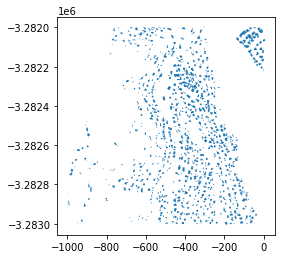

In [ ]:
mask_plot = gpd.read_file(shp_path)
mask_plot["geometry"].plot();

In [ ]:
print(f'Number of images: {len(images_list)}')
print(images_list[0])

Number of images: 12
/content/drive/MyDrive/Segmentation Data/aerial/images/2019_10cm_RGB_BE_67.tif


Create Masks Corresponding to Selected Images

In [ ]:
# Create masks corresponding to selected images
save_masks(images_list, shp_path, path/f'untiled masks/{mask_type}')

Tile Selected Images and Corresponding Masks

In [ ]:
# Tile images and masks with a stride of 0 pixels
tile_size = 512
tile_img_msk(images_list, tile_size)

Tile Only Selected Image(s)

In [ ]:
tile_size = 500
output_path = path/"inference/input"
if not os.path.exists(str(output_path)):
  os.makedirs(str(output_path))

tile_img(images_list, output_path, tile_size, single = False)

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
100%|██████████| 12/12 [10:58<00:00, 54.87s/it]


In [ ]:
# Sanity check
print(len(get_image_files(output_path)))
print(len(images_list * 400))

4800
4800
